In [1]:
# Imports 
import os
import matplotlib.pyplot as plt
from array import array
from ROOT import TFile, TTree
import numpy as np
plt.rc('text', usetex=True)
import ROOT
import random

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gl95zzq7 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Welcome to JupyROOT 6.22/06


In [9]:
a=np.array([5,3,7,6,9])
a[[1,2,3]]

array([3, 7, 6])

In [ ]:
def get_dirs(PROJECT_NAME,MLmethod):
    pathtowork="/work/clas12/users/gmat/scipio/projects"
    pathtovolatile="/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/projects"
    dirs = [d for d in os.listdir(f"{pathtovolatile}/{PROJECT_NAME}/{MLmethod}/postprocess_binned")]
    bindirs = []
    for d in dirs:
        if ("bru" in d or "sdbnd" in d):
            continue
        else:
            bindirs.append(f"{pathtovolatile}/{PROJECT_NAME}/{MLmethod}/postprocess_binned/{d}")
    outdir=f"{pathtowork}/{PROJECT_NAME}/{MLmethod}/asymPlots"
    return bindirs,outdir

In [432]:
def save_names(split_names):
    name_list.append(split_names[0::3])
    min_list.append(split_names[1::3])
    max_list.append(split_names[2::3])


def get_sorted_plots(plots,skipEdges=False):
    
    

    # Create a new dict to store the sorted plots
    sorted_plots = []
    
    for plot in plots:
        sorted_plot={}
        # Get the sorted index of centers
        sorted_index = np.lexsort(tuple([plot["centers"][:,n] for n in range(plot["centers"].shape[1])]))
        if(skipEdges):
            ny = np.count_nonzero(plot["centers"][:,0]==plot["centers"][0][0])
            nx = int(len(plot["centers"])/ny)
            
            sorted_index=list(sorted_index)
            del sorted_index[::nx]
            del sorted_index[nx-2::nx-1]
            sorted_index=np.array(sorted_index)

        # Iterate through the keys in plots
        for key in plot.keys():
            if key == 'name':
                sorted_plot['name']=plot[key]
                continue
            if(key=="h1diphoton" or key=="f1diphoton"):
                arr=[plot[key][si] for si in sorted_index]
                sorted_plot[key]=arr
            else:
                sorted_plot[key]=plot[key][sorted_index]
        sorted_plots.append(sorted_plot)
    
    return sorted_plots

def get_modulations(L):
    char_vec = []
    str_vec = []
    for l in range(0, L+1):
        for m in range(1, l+1):
            if(m==1):
                string = "\sin(" + "\phi_{h}-" + "\phi_{R})"
            else:
                string = "\sin(" + str(m) +"\phi_{h}-" + str(m) +"\phi_{R})"
            str_vec.append(string)
        for m in range(-l, l+1):
            if(m==1):
                string = "\sin("+"\phi_{R})"
            elif(m==2):
                string = "\sin("  + "-\phi_{h}+" + str(m) +"\phi_{R})"
            elif(m==0):
                string = "\sin("+"\phi_{h})"
            elif(m==-1):
                string = "\sin(" + str(1-m) + "\phi_{h}-" + "\phi_{R})"
            elif(m<0):
                string = "\sin(" + str(1-m) + "\phi_{h}" + str(m) +"\phi_{R})"
            else:
                string = "\sin(" + str(1-m) + "\phi_{h}+" + str(m) +"\phi_{R})"
            str_vec.append(string)
    # Remove duplicate entries
    str_vec.sort()
    str_vec = list(dict.fromkeys(str_vec))
    cidx = 0
    for c in range(ord('A'), ord('A')+len(str_vec)):
        string = ""
        string += chr(c)
        char_vec.append(string)
        cidx += 1
    return (char_vec, str_vec)

NameError: name 'plots' is not defined

In [238]:
def roohist_to_th1d(roohist):
    
    width = roohist.GetPointX(2)-roohist.GetPointX(1)
    N = roohist.GetN()
    MIN = roohist.GetPointX(0)-0.5*width
    MAX = roohist.GetPointX(N-1)+0.5*width
    th1d = ROOT.TH1D("","",N,MIN,MAX)
    th1d.SetDirectory(0)
    for i in range(1,N+1):
        th1d.SetBinContent(i,roohist.GetPointY(i-1))
    return th1d

In [431]:
def get_fit_lists(input_dir, version="splot",datatype="nSidis",ML=""):
    assert(version=="splot" or version=="sideband")
    
    name_list = []
    min_list = []
    max_list = []
    nll_list = []

    yld_azi_list = []
    yld_azi_err_list = []

    param_sig_list = []
    param_sigbg_list = []
    param_bg_list = []
    err_sig_list = []
    err_sigbg_list = []
    err_bg_list = []
    
    param_name_list = []
    err_name_list = []
    
    h1diphoton = []
    f1diphoton = []
    

    if(version=="splot"):
        # Outer loop
        for subdir in os.listdir(f"{input_dir}/bru_obs"):
            if(not subdir.startswith(datatype) or (datatype=="nSidis" and "bending" in subdir) or (("noML" in subdir) != ("noML" in ML))):
                continue
            # Get the histogram and fit curve
            fdiphoton = TFile(f"{input_dir}/bru_out/{subdir}/ResultsHSMinuit2.root")
            c1=fdiphoton.Get("_Mgg")
            tpad1=c1.GetPrimitive("_Mgg_1")
            
            
            # Split the subdirectory name
            split_names = subdir.replace(f"{datatype}_","").split("_")
            
            
            # Save TObjects
            h1=tpad1.GetPrimitive("h_DataEvents")
            h1=roohist_to_th1d(h1)
            h1name="h1_"
            for sn in split_names:
                h1name+=sn+"_"
            h1.SetName(h1name)
            f1=tpad1.GetPrimitive("TotalPDF_Norm[Mgg]")
            f1.SetTitle("f1_{}".format(split_names))
            
            # Open the TFile
            f = TFile(f"{input_dir}/bru_obs/{subdir}/ResultsHSMinuit2.root")
            
            
            # Open the TTree
            print(subdir)
            t = f.Get("ResultTree")
            t.GetEntry(0)
            

            # Get the TBranches
            nll = t.GetBranch("NLL")
            yld_azi = t.GetBranch("Yld_AziFit")
            yld_azi_err = t.GetBranch("Yld_AziFit_err")

            # Get the remaining TBranch names
            branches = []
            for i in range(0, t.GetListOfBranches().GetEntries()-3):
                branches.append(t.GetListOfBranches().At(i).GetName())

            # Get the entries from the TBranch
            nll_list.append(nll.GetEntry(0))
            yld_azi_list.append(yld_azi.GetEntry(0))
            yld_azi_err_list.append(yld_azi_err.GetEntry(0))

            for branch in branches:
                if branch.endswith("err"):
                    exec("err_sig_list.append(t.{})".format(branch))
                    err_name_list.append(branch)
                    name_list.append(split_names[0::3])
                    min_list.append(split_names[1::3])
                    max_list.append(split_names[2::3])
                    h1diphoton.append(h1)
                    f1diphoton.append(f1.Clone())
                else:
                    exec("param_sig_list.append(t.{})".format(branch))
                    param_name_list.append(branch)
                    
    elif(version=="sideband"):
        # Outer loop
        
        for subdir in os.listdir(f"{input_dir}/sdbnd_obs"):
            
            if((not subdir.startswith(datatype)) or (datatype=="nSidis" and "bending" in subdir) or (("noML" in subdir) != ("noML" in ML))):
                continue
            
            fdiphoton = TFile(f"{input_dir}/sdbnd_out/{subdir}/sideband.root","READ")
            purity = fdiphoton.Get("purity")[0]
            
            # Split the subdirectory name
            split_names = subdir.replace(f"{datatype}_","").split("_")
            
            
            # Save TObjects
            h1=fdiphoton.Get("Mdiphoton_normed")
            h1name="h1_"
            for sn in split_names:
                h1name+=sn+"_"
            h1.SetName(h1name)
            h1.SetDirectory(0)
            f1=fdiphoton.Get("f_sdbnd")
            f1.SetTitle("f1_{}".format(split_names))
            
            
            # Open the TFile
            fsigbg = TFile(f"{input_dir}/sdbnd_obs/{subdir}/sigbg/ResultsHSMinuit2.root")
            
            
            # Open the sigbg TTree
            tsigbg = fsigbg.Get("ResultTree")
            tsigbg.GetEntry(0)
            
            
            # Get the TBranches
            nll = tsigbg.GetBranch("NLL")
            yld_azi = tsigbg.GetBranch("Yld_AziFit")
            yld_azi_err = tsigbg.GetBranch("Yld_AziFit_err")
            
            
            # Get the remaining TBranch names
            branches = []
            for i in range(0, tsigbg.GetListOfBranches().GetEntries()-3):
                branches.append(tsigbg.GetListOfBranches().At(i).GetName())

            # Get the entries from the TBranch
            
            
            nll_list.append(nll.GetEntry(0))
            yld_azi_list.append(yld_azi.GetEntry(0))
            yld_azi_err_list.append(yld_azi_err.GetEntry(0))

            for branch in branches:
                if branch.endswith("err"):
                    exec("err_sigbg_list.append(tsigbg.{})".format(branch))
                    err_name_list.append(branch)
                    name_list.append(split_names[0::3])
                    min_list.append(split_names[1::3])
                    max_list.append(split_names[2::3])
                else:
                    exec("param_sigbg_list.append(tsigbg.{})".format(branch))
                    param_name_list.append(branch)
                    
            # Open the bg TTree
            
            
            tbg = fsigbg.Get("ResultTree")
            tbg.GetEntry(0)
            
            
            # Get the remaining TBranch names
            branches = []
            for i in range(0, tbg.GetListOfBranches().GetEntries()-3):
                branches.append(tbg.GetListOfBranches().At(i).GetName())
                
            for branch in branches:
                if branch.endswith("err"):
                    exec("err_bg_list.append(tbg.{})".format(branch))
                else:
                    exec("param_bg_list.append(tbg.{})".format(branch))
            
            for k,[par_sigbg, par_bg, err_sigbg, err_bg] in enumerate(zip(param_sigbg_list,param_bg_list,
                                                            err_sigbg_list, err_bg_list)):
                if(k<len(param_sig_list)):
                    continue
                else:
                    param_sig_list.append((1.0/purity)*par_sigbg-((1.0-purity)/purity)*par_bg)
                    err_sig_list.append(np.sqrt((err_sigbg/purity)**2+(err_bg*(1.0-purity)/purity)**2))
                    h1diphoton.append(h1)
                    f1diphoton.append(f1)
                    
                    
    return (name_list, min_list, max_list, nll_list,  h1diphoton, f1diphoton, yld_azi_list, yld_azi_err_list, param_sig_list, param_sigbg_list, param_bg_list, err_sig_list, err_sigbg_list, err_bg_list, param_name_list, err_name_list)

In [270]:
# Initializing lists 
def collect(input_dir,version="splot",skipEdges=False,datatype="nSidis",ML=""):
    
    (name_list, min_list, max_list, nll_list, h1diphoton, f1diphoton, yld_azi_list, yld_azi_err_list, param_sig_list, param_sigbg_list, param_bg_list, err_sig_list, err_sigbg_list, err_bg_list, param_name_list, err_name_list)\
    = get_fit_lists(input_dir,version,datatype,ML)
    # Comparing each "A", "B", etc. list
    plots=[]
    unique_name_list = list(set([tuple(sublist) for sublist in name_list]))
    for name in unique_name_list:
        name=list(name)
        plotdict={}
        plotdict["name"]=name
        BOOL =  [True if n == name else False for n in name_list]
        parNames = np.array(param_name_list)[BOOL]
        errNames = np.array(err_name_list)[BOOL]
        par = np.array(param_sig_list)[BOOL]
        err = np.array(err_sig_list)[BOOL]
        left = np.array(min_list,dtype=float)[BOOL]
        right = np.array(max_list,dtype=float)[BOOL]
        center = 0.5*(left+right)
        h1=[]
        f1=[]
        for h,f,b in zip(h1diphoton,f1diphoton,BOOL):
            if b==True:
                h1.append(h)
                f1.append(f)
        for p in parNames:
            BOOL =  [True if n == p else False for n in parNames]
            left2   = left[BOOL]
            right2  = right[BOOL]
            center2 = center[BOOL]
            h2=[]
            f2=[]
            for h,f,b in zip(h1,f1,BOOL):
                if b==True:
                    h2.append(h)
                    f2.append(f)
            plotdict["centers"]=center2
            plotdict["leftEdge"]=left2
            plotdict["rightEdge"]=right2
            plotdict["h1diphoton"]=h2
            plotdict["f1diphoton"]=f2
            par2  = par[BOOL]
            plotdict[p]=par2

        for e in errNames:
            BBOOL =  [True if n == e else False for n in errNames]
            err2 = err[BOOL]

            plotdict[e]=err2

        plots.append(plotdict)
    # Sort by center
    plots=get_sorted_plots(plots,skipEdges)
    
    return plots

In [271]:
def make_azi_plots(params,version,outdir,datatype="nSidis",ML=""):
    for plot in params:
        variables = [key for key in plot.keys() if not ("diphoton" in key or key.endswith('_err') or key.endswith('Edge') or key=="name" or key=="centers")]
        nVar = len(variables)


        mods = get_modulations(2)[1]
        rows = (len(variables) // 4) + 1
        fig, axes = plt.subplots(rows, 4, figsize=(14, 3 * rows),dpi=150)

        yvals = [y for var in variables for y in plot[var] ]
        yerrs = [y for var in variables for y in plot[var+"_err"] ]
        ymax = (np.amax(np.abs(yvals))+np.amax(np.abs(yerrs)))*1.1
        for var,mod,ax in zip(variables,mods,axes.flatten()):
            nNames = len(plot["name"])
            subNames = plot["name"][1:]
            unique_centers = np.unique(plot["centers"][:,1:],axis=0)
            unique_lefts = np.unique(plot["leftEdge"][:,1:],axis=0)
            unique_rights = np.unique(plot["rightEdge"][:,1:],axis=0)
            if(nNames==1):
                x = plot['centers'][:,0]
                y = plot[var]
                yerr = plot[var + '_err']
                ax.errorbar(x, y, yerr=yerr,fmt="o",capsize=2)
                if(plot['name'][0]=="Mh"):
                    ax.set_xlabel(r"$M_{h}$[GeV]")
                else:
                    ax.set_xlabel(plot['name'][0])
                ax.set_ylim(-ymax,ymax)
                ax.grid()
                ax.axhline(0, ls='--', color='black',alpha=0.5)
                ax.set_title(r'${}$'.format(mod))
            else:
                for i in range(len(unique_centers)):
                    ucs = list(unique_centers[i])
                    BOOL = [True if list(pc)==ucs else False for pc in plot['centers'][:,1:] ]
                    x = plot['centers'][:,0][BOOL]
                    xl = plot['leftEdge'][:,1:][BOOL]
                    xr = plot['rightEdge'][:,1:][BOOL] 
                    y = plot[var][BOOL]
                    yerr = plot[var + '_err'][BOOL]
                    mylabel=""
                    for k,[bl,br,nom] in enumerate(zip(xl[0],xr[0],subNames)):
                        if(nom=="Mh"):
                            nom="M_{h}"
                        mylabel+="{}<{}<{}".format(bl,nom,br)
                        if(k!=len(xl[0])-1):
                            mylabel+="\,|\,"
                    mylabel=r"${}$".format(mylabel)

                    ax.errorbar(x, y, yerr=yerr,fmt="o",capsize=2, label=mylabel)
                    ax.set_xlabel(plot['name'][0])
                    ax.set_ylim(-ymax,ymax)
                    ax.grid()
                    ax.axhline(0, ls='--', color='black',alpha=0.5)
                ax.legend()    
                ax.set_title(r'${}$'.format(mod))

        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        while(nVar < len(axes.flatten())):
            fig.delaxes(axes.flatten()[-1])
            nVar+=1
        varlist=""
        for v in plot["name"]:
            varlist+=v+"_"
        if(ML=="noML"):
            varlist="noML_"+varlist
        plt.savefig(f"{outdir}/{varlist}{version}.png")

In [430]:
def make_mdiphoton_plots(params,skipEdges=False,suffix=""):
    for plot in params:

        dim=len(plot["leftEdge"][0])
        if(dim>2):
            print("Can only do Mdiphoton plotting for dim<=2...Aborting...")
            break



        # Set global parameters
        cleft=-20
        cright=20
        cup=1
        cdown=-1
        xaxis_h = -0.8
        xaxis_l = -15
        xaxis_r = 18
        padtop=0.8
        padbot=0.2

        padtopscale=(cup-cdown)*padtop+cdown
        padbotscale=(cup-cdown)*padbot+cdown

        #Create TCanvas
        c=ROOT.TCanvas("c","c",1200,600)
        c.Range(cleft,cdown,cright,cup)


        # Get xmin and xmax
        leftEdge=np.unique(plot["leftEdge"][:,0])
        rightEdge=np.unique(plot["rightEdge"][:,0])
        xmin=leftEdge[0]
        xmax=rightEdge[-1]
        if(dim==2):
            bottomEdge=np.unique(plot["leftEdge"][:,1])
            topEdge=np.unique(plot["rightEdge"][:,1])
            ymin = bottomEdge[0]
            ymax = topEdge[-1]

        # Set number of xbins
        nxbins=len(leftEdge)
        # Set number of ybins
        nybins=1
        if(dim==2):
            nybins=len(topEdge)

        # Set TPad box size
        boxheight=(padtop-padbot)/nybins


        # Get bins
        bins = sorted(np.unique(np.concatenate([leftEdge,rightEdge])))

        # Create axes
        # If dimension == 2, make a y axis as well
        xaxis=ROOT.TGaxis(xaxis_l,xaxis_h,xaxis_r,xaxis_h,xmin,xmax,510,"<")
        xaxis.SetTitle(plot["name"][0])
        xaxis.Draw()

        if(dim==2):
            yaxis=ROOT.TGaxis(xaxis_l-1,padbotscale,xaxis_l-1,padtopscale,ymin,ymax,508,"")
            yaxis.SetTitle(plot["name"][1])
            yaxis.Draw("same")

        # Scale bins to axes
        bins_scaled =(( (bins - np.min(bins)) * (xaxis_r - (xaxis_l)) / (np.max(bins) - np.min(bins)) + (xaxis_l)) - cleft)/ (cright-cleft) 
        bins_scaled_v2 =( (bins - np.min(bins)) * (xaxis_r - (xaxis_l)) / (np.max(bins) - np.min(bins)) + (xaxis_l))
        # Find the ymax for the fits
        ymax=0
        for h in plot["h1diphoton"]:
            if(h.GetMaximum()>ymax):
                ymax=h.GetMaximum()
        # For each mdiphoton
        xxaxis=[]
        i=0
        inc=0
        ix,iy=0,0
        for h,f in zip(plot["h1diphoton"],plot["f1diphoton"]):
            if(ix==nxbins):
                ix=0
                iy+=1
            xxaxis.append(ROOT.TGaxis(bins_scaled_v2[ix],padbotscale,bins_scaled_v2[ix+1],padbotscale,h.GetXaxis().GetXmin(),h.GetXaxis().GetXmax(),504,""))
            xxaxis[i].SetLabelSize(0.02)

            tpad = ROOT.TPad("","",bins_scaled[ix],padbot+boxheight*iy,bins_scaled[ix+1],padbot+boxheight*(iy+1))
            tpad.Draw("same")
            tpad.cd()
            tpad.SetLeftMargin(0)
            tpad.SetRightMargin(0)


            tpad.SetTopMargin(0)
            tpad.SetBottomMargin(0)
            f.GetYaxis().SetRangeUser(0,ymax*1.1)
            f.SetTitle("")
            f.Draw()
            h.SetLineColor(1)
            h.Draw("hist same")

        
            c.cd()
            xxaxis[i].SetTickLength(5)
            xxaxis[i].Draw("same")
            
            i=i+1
            inc=inc+1
            ix+=1
            
        latex=ROOT.TLatex()
        latex.DrawLatexNDC(0.96,padbot-0.02,"M_{#gamma#gamma}")
        
        plotname = ""
        for n in plot["name"]:
            plotname+=n+"_"
        if(skipEdges):
            plotname+="abbrev_"
        else:
            plotname+="full_"
        plotname+=suffix
        c.SaveAs("/work/clas12/users/gmat/scipio/macros/analysis/plots/mdiphoton_{}.png".format(plotname))

In [428]:
#params=collect("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/catboost/binned_pipluspi0/test2d","splot")

In [429]:
#make_mdiphoton_plots(params,True)

3 0 3 0 18
4 1 3 0 18
5 2 3 0 18
6 3 3 1 18
7 4 3 1 18
8 5 3 1 18
9 6 3 2 18
10 7 3 2 18
11 8 3 2 18
12 9 3 3 18
13 10 3 3 18
14 11 3 3 18
15 12 3 4 18
16 13 3 4 18
17 14 3 4 18
18 15 3 5 18
19 16 3 5 18
20 17 3 5 18
3 0 3 0 18
4 1 3 0 18
5 2 3 0 18
6 3 3 1 18
7 4 3 1 18
8 5 3 1 18
9 6 3 2 18
10 7 3 2 18
11 8 3 2 18
12 9 3 3 18
13 10 3 3 18
14 11 3 3 18
15 12 3 4 18
16 13 3 4 18
17 14 3 4 18
18 15 3 5 18
19 16 3 5 18
20 17 3 5 18


Info in <TCanvas::Print>: png file /work/clas12/users/gmat/scipio/src/plot_a.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /work/clas12/users/gmat/scipio/src/plot_a.png has been created


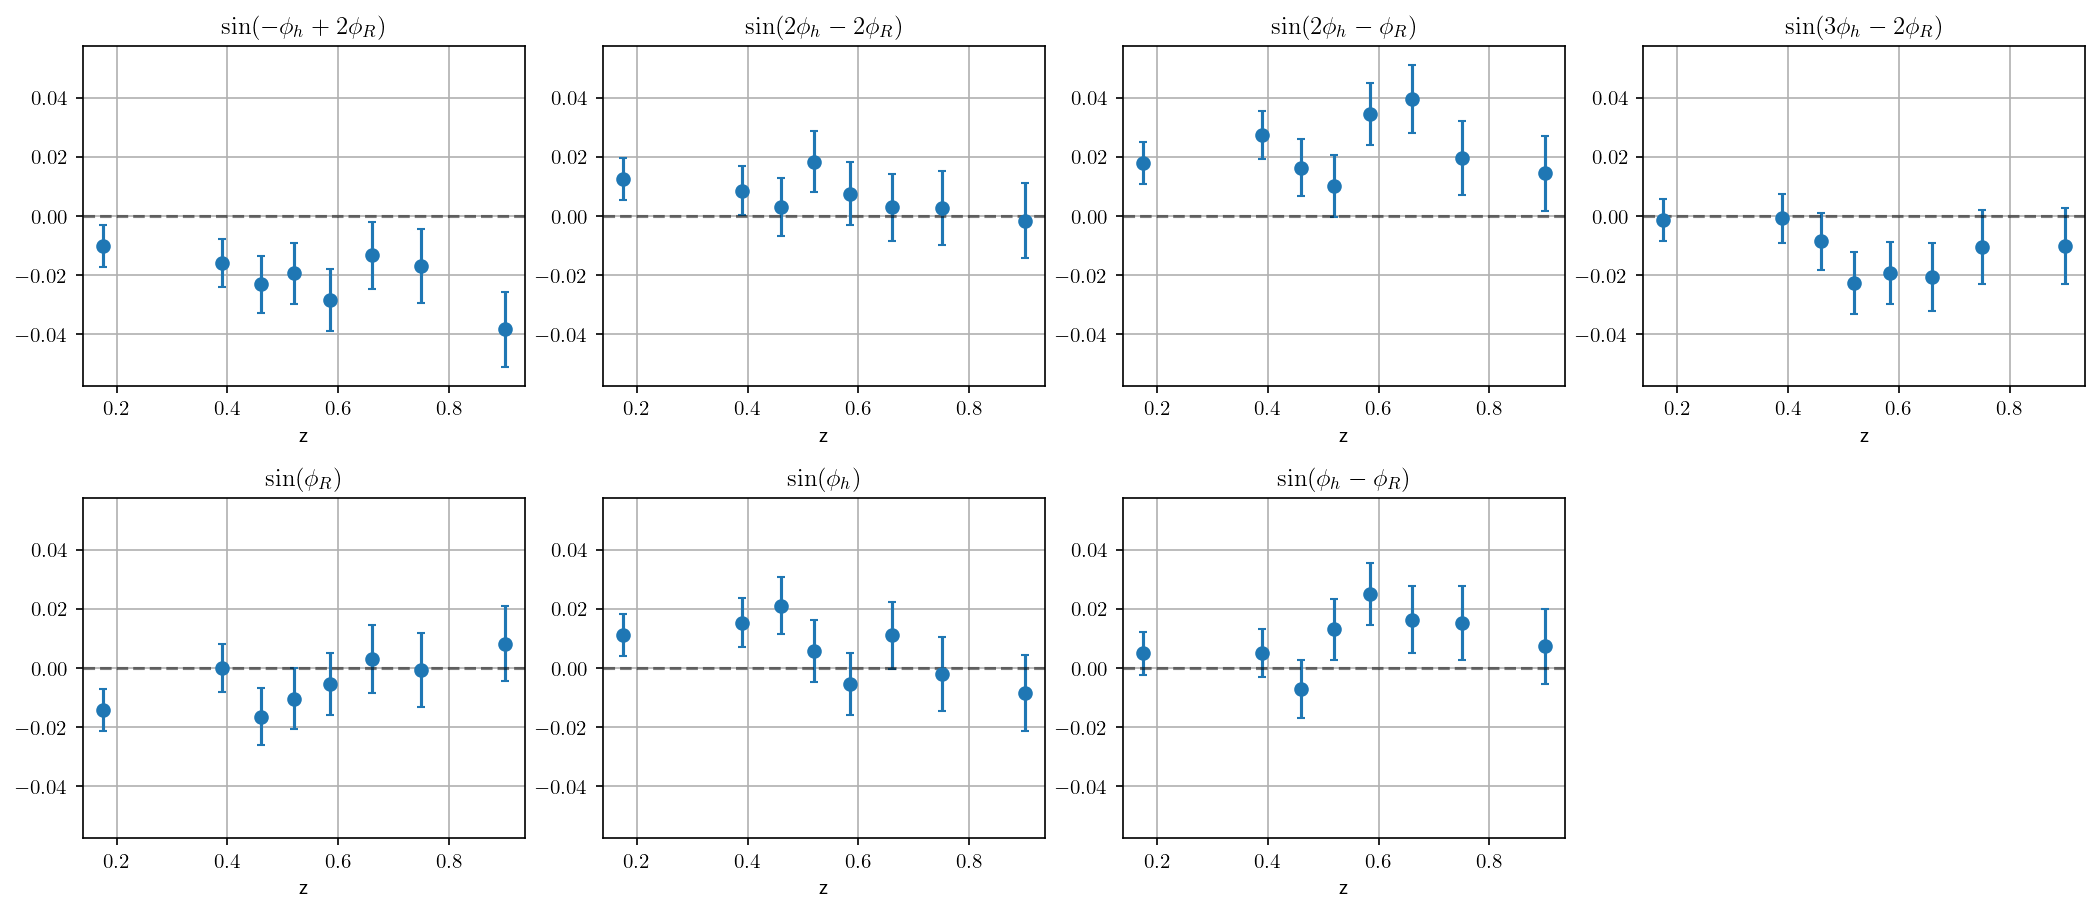

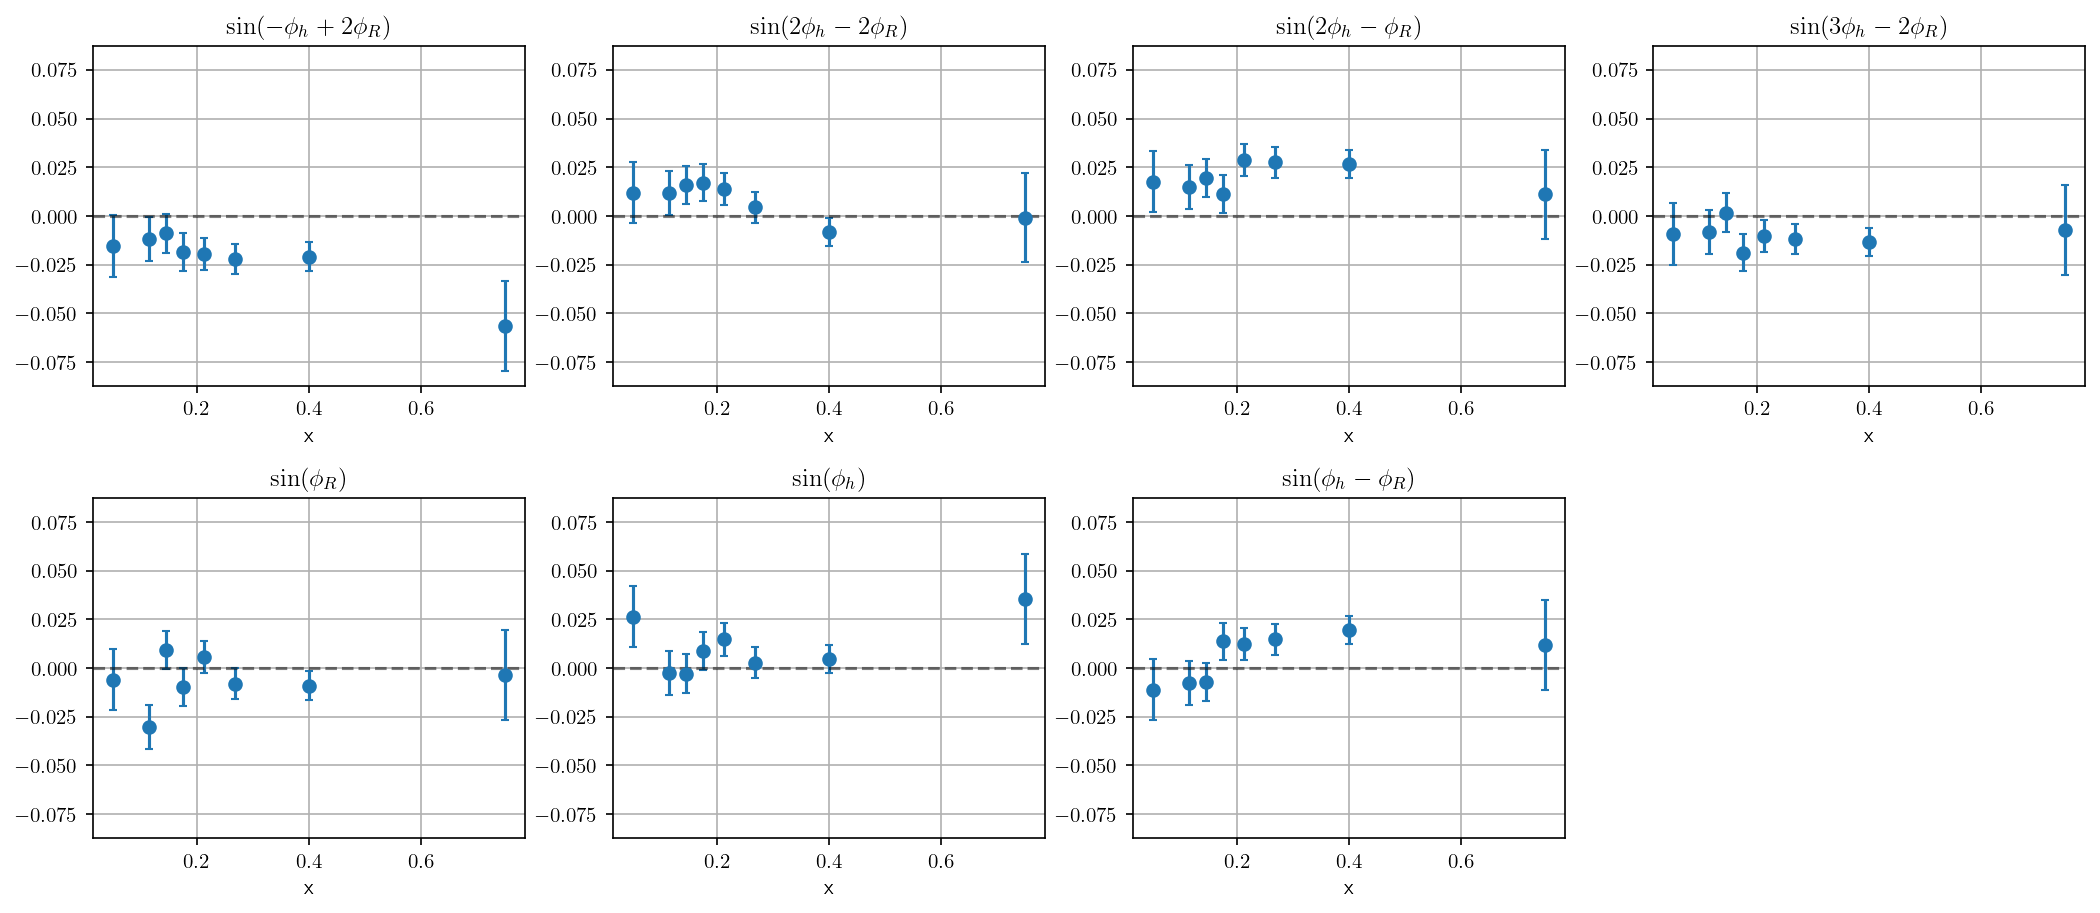

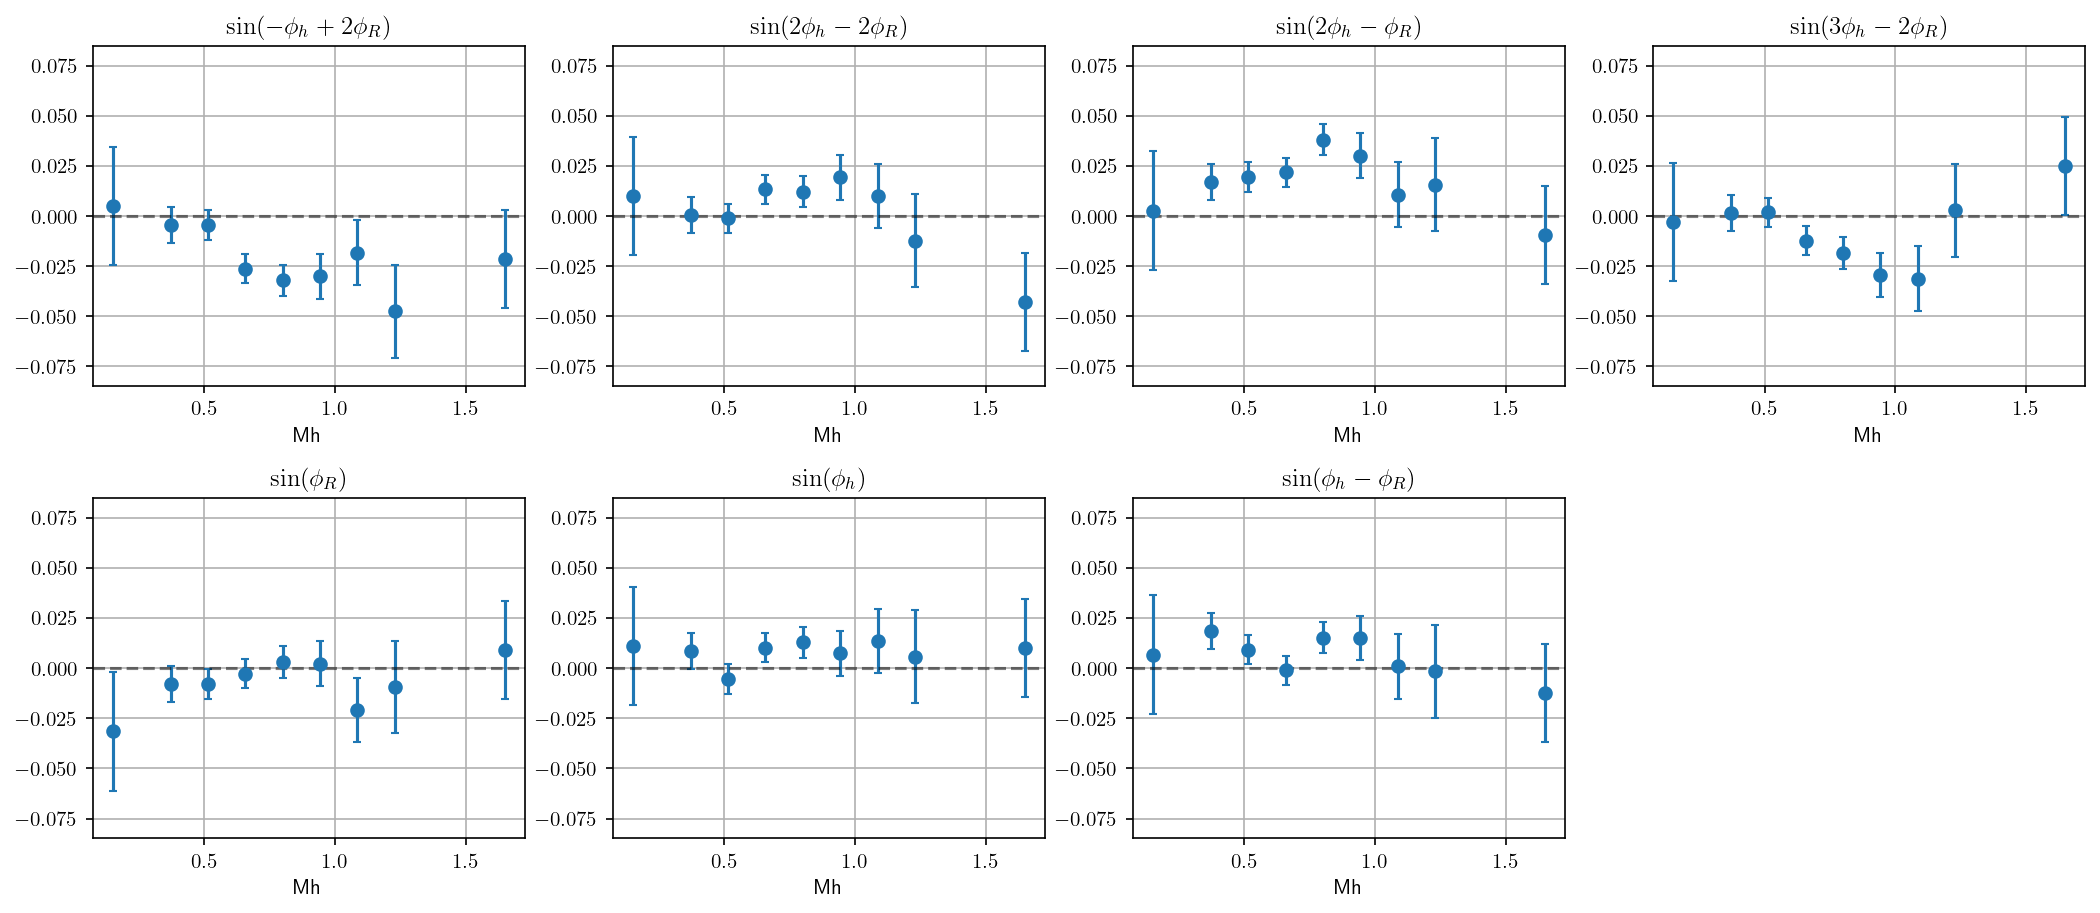

In [7]:
#make_azi_plots(params)

In [338]:
#params=collect("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/ML/catboost/binned_pipluspi0/test2d","sideband")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


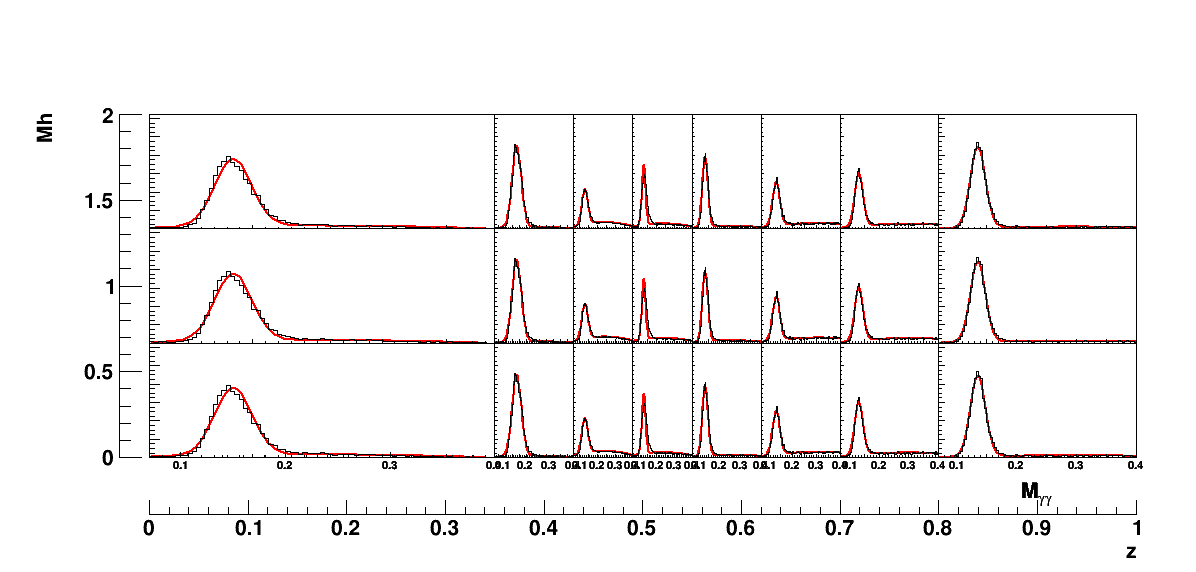

In [339]:
# for plot in params:
    
#     dim=len(plot["leftEdge"][0])
#     if(dim>2):
#         print("Can only do Mdiphoton plotting for dim<=2...Aborting...")
#         break
    
   

#     # Set global parameters
#     cleft=-20
#     cright=20
#     cup=1
#     cdown=-1
#     xaxis_h = -0.8
#     xaxis_l = -15
#     xaxis_r = 18
#     padtop=0.8
#     padbot=0.2
    
#     padtopscale=(cup-cdown)*padtop+cdown
#     padbotscale=(cup-cdown)*padbot+cdown
    
#     #Create TCanvas
#     c=ROOT.TCanvas("c","c",1200,600)
#     c.Range(cleft,cdown,cright,cup)
    
    
#     # Get xmin and xmax
#     leftEdge=plot["leftEdge"][:,0]
#     rightEdge=plot["rightEdge"][:,0]
#     xmin=leftEdge[0]
#     xmax=rightEdge[-1]
#     if(dim==2):
#         bottomEdge=np.unique(plot["leftEdge"][:,1])
#         topEdge=np.unique(plot["rightEdge"][:,1])
#         ymin = bottomEdge[0]
#         ymax = topEdge[-1]
    
#     # Set number of ybins
#     nybins=1
#     if(dim==2):
#         nybins=len(topEdge)
        
#     # Set TPad box size
#     boxheight=(padtop-padbot)/nybins
    

#     # Get bins
#     bins = sorted(np.unique(np.concatenate([leftEdge,rightEdge])))
    
#     # Create axes
#     # If dimension == 2, make a y axis as well
#     xaxis=ROOT.TGaxis(xaxis_l,xaxis_h,xaxis_r,xaxis_h,xmin,xmax,510,"<")
#     xaxis.SetTitle(plot["name"][0])
#     xaxis.Draw()
    
#     if(dim==2):
#         yaxis=ROOT.TGaxis(xaxis_l-1,padbotscale,xaxis_l-1,padtopscale,ymin,ymax,508,"")
#         yaxis.SetTitle(plot["name"][1])
#         yaxis.Draw("same")
        
#     # Scale bins to axes
#     bins_scaled =(( (bins - np.min(bins)) * (xaxis_r - (xaxis_l)) / (np.max(bins) - np.min(bins)) + (xaxis_l)) - cleft)/ (cright-cleft) 
#     bins_scaled_v2 =( (bins - np.min(bins)) * (xaxis_r - (xaxis_l)) / (np.max(bins) - np.min(bins)) + (xaxis_l))
#     # Find the ymax for the fits
#     ymax=0
#     for h in plot["h1diphoton"]:
#         if(h.GetMaximum()>ymax):
#             ymax=h.GetMaximum()
#     # For each mdiphoton
#     xxaxis=[]
#     for i,[h,f] in enumerate(zip(plot["h1diphoton"],plot["f1diphoton"])):
#         idx=int(i/nybins)
#         xxaxis.append(ROOT.TGaxis(bins_scaled_v2[idx],padbotscale,bins_scaled_v2[idx+1],padbotscale,h.GetXaxis().GetXmin(),h.GetXaxis().GetXmax(),504,""))
#         if(i==len(plot["h1diphoton"])-1):
#             xxaxis[i].SetTitle("M_{#gamma#gamma}")
#             xxaxis[i].CenterTitle(1)
#         xxaxis[i].SetLabelSize(0.02)

#         for j in range(nybins):
#             tpad = ROOT.TPad("","",bins_scaled[idx],padbot+boxheight*j,bins_scaled[idx+1],padbot+boxheight*(j+1))
#             tpad.Draw("same")
#             tpad.cd()
#             tpad.SetLeftMargin(0)
#             tpad.SetRightMargin(0)


#             tpad.SetTopMargin(0)
#             tpad.SetBottomMargin(0)
#             f.GetYaxis().SetRangeUser(0,ymax*1.1)
#             f.SetTitle("")
#             f.Draw()
#             h.SetLineColor(1)
#             h.Draw("hist same")

#             c.cd()
#             xxaxis[i].SetTickLength(5)
#             xxaxis[i].Draw("same")
#     c.Draw()